set directory

In [1]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)

In [21]:
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)

open and save image

In [22]:
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))


transform image to HOG features

In [23]:
winSize=(64,64)
blockSize=(16,16)
blockStride=(8,8)
cellSize=(8,8)
nbins=9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [24]:
padding=(0,0)
winStride=(8, 8)
imginhog=[]
for i in images:
    img=hog.compute(cv2.resize(i,(64,64)), winStride=winStride, padding=padding)
    imginhog.append(img)

In [25]:
imginhogarr=np.asarray(imginhog).reshape(64225, np.asarray(imginhog).shape[1])
imagescatarr=np.asarray(imagescat)

save / load features dataset

In [47]:
np.save('imginhogarr', imginhogarr)
np.save('imagescatarr', imagescatarr)

In [49]:
import cv2
import numpy as np
from numpy import asarray
imginhogarr=np.load('imginhogarr.npy')
imagescatarr=np.load('imagescatarr.npy')

turn y to one hot vector

In [51]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(imagescatarr)
encoded_imagescatarr = encoder.transform(imagescatarr)
# convert integers to dummy variables (i.e. one hot encoded)
imagescatarr = np_utils.to_categorical(encoded_imagescatarr)

split dataset into train/valid/test

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imginhogarr,imagescatarr, test_size=0.1, random_state=0)

split_indext = np.concatenate((np.ones(round(len(y_trainvalid)*0.8)), np.zeros(round(len(y_trainvalid)*0.2))), axis=None)
split_indexv = np.concatenate((np.zeros(round(len(y_trainvalid)*0.8)), np.ones(round(len(y_trainvalid)*0.2))), axis=None)


develop MLP model

In [101]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

network = models.Sequential()
network.add(layers.Dense(545, activation='relu', input_shape=(1764,)))
network.add(layers.Dense(165, activation='relu'))
network.add(layers.Dense(50, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
history = network.fit(X_trainvalid[split_indext.astype(bool)], y_trainvalid[split_indext.astype(bool)],
                    validation_data=(X_trainvalid[split_indexv.astype(bool)], y_trainvalid[split_indexv.astype(bool)]),
                    epochs=100,batch_size=50,callbacks=earlyStopping)

Epoch 1/100
925/925 [==============================] - 4s 4ms/step - loss: 3.8498 - accuracy: 0.0349 - val_loss: 3.7474 - val_accuracy: 0.0473
Epoch 2/100
925/925 [==============================] - 3s 3ms/step - loss: 3.6867 - accuracy: 0.0628 - val_loss: 3.6248 - val_accuracy: 0.0702
Epoch 3/100
925/925 [==============================] - 3s 3ms/step - loss: 3.5965 - accuracy: 0.0782 - val_loss: 3.5802 - val_accuracy: 0.0772
Epoch 4/100
925/925 [==============================] - 3s 3ms/step - loss: 3.5385 - accuracy: 0.0917 - val_loss: 3.5445 - val_accuracy: 0.0864
Epoch 5/100
925/925 [==============================] - 3s 3ms/step - loss: 3.4850 - accuracy: 0.1033 - val_loss: 3.5017 - val_accuracy: 0.0990
Epoch 6/100
925/925 [==============================] - 3s 3ms/step - loss: 3.4517 - accuracy: 0.1084 - val_loss: 3.5158 - val_accuracy: 0.0971
Epoch 7/100
925/925 [==============================] - 3s 3ms/step - loss: 3.4187 - accuracy: 0.1157 - val_loss: 3.4689 - val_accuracy: 0.1080

plot learning curve

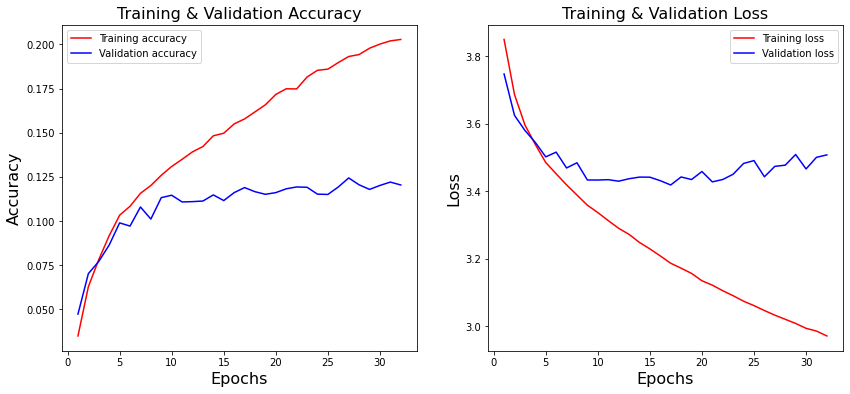

In [102]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Comparing predicted vs actual  

the code shown here are for validation  

change '_trainvalid[split_indexv.astype(bool)]' to '_test' for testing

In [166]:
predictions=network.predict(X_trainvalid[split_indexv.astype(bool)])
prediction_ = np.argmax(predictions, axis = 1)
prediction_ = encoder.inverse_transform(prediction_)
actual_ = np.argmax(y_trainvalid[split_indexv.astype(bool)], axis = 1)
actual_ = encoder.inverse_transform(actual_)

In [167]:
# top1 accuracy
np.mean(prediction_==actual_ )

0.12041522491349481

In [168]:
maxfive=np.argsort(predictions, axis=1)[:,-5:]
maxfive

array([[29, 28, 46,  7,  8],
       [28, 11,  2, 23,  8],
       [12, 19, 17, 22, 18],
       ...,
       [49, 19, 46, 20, 44],
       [23,  1, 14, 39,  2],
       [16, 19, 14, 12, 22]])

In [172]:
actual= np.argmax(y_trainvalid[split_indexv.astype(bool)], axis = 1).reshape(-1,1)
actual

array([[ 7],
       [ 0],
       [14],
       ...,
       [33],
       [34],
       [ 2]])

In [173]:
# top5 accuracy
np.mean((actual==maxfive).sum(-1))

0.36972318339100346